In [105]:
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.linear_model import LinearRegression
import json

In [125]:
def process_image(image_path):
    pic = skimage.io.imread(fname=image_path)
    R, G, B = pic[:,:,0], pic[:,:,1], pic[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B
    plt.imshow(imgGray, cmap='gray')
    plt.grid(which='both')
    plt.minorticks_on()
    plt.colorbar()
    plt.show()
    
    iar = np.asarray(imgGray)
    val = iar[iar > 10]
    avg_intensity = sum(val) / len(val)
    print(f"The average intensity for the image is {round(avg_intensity, 4)}")
    
    return avg_intensity

In [126]:
def plot_intensity_vs_thickness(thickness, intensity):
    plt.scatter(thickness, intensity, label='Data')

    x_reshaped = np.array(thickness).reshape(-1, 1)
    reg = LinearRegression().fit(x_reshaped, intensity)
    m = reg.coef_[0]
    b = reg.intercept_
    r_sq = reg.score(x_reshaped, intensity)

    x = np.linspace(min(thickness), max(thickness), 100)
    v = m * x + b

    plt.plot(x, v, label=f'Linear regression\n$R^2$ value: {r_sq:.5f}', color='r')

    plt.title('Intensity vs. Thickness')
    plt.xlabel('Thickness ($\mu$m)')
    plt.ylabel('Intensity')
    plt.minorticks_on()
    plt.grid()
    plt.legend()
    plt.savefig('thickness_intensity_plot.png', dpi=650)
    plt.show()

    print('y =', m, 'x +', b)

    model_params = {'slope': m, 'intercept': b}
    with open('model_params.json', 'w') as f:
        json.dump(model_params, f)
    
    return reg

In [127]:
def load_model_params():
    with open('model_params.json', 'r') as f:
        model_params = json.load(f)
    return model_params

In [128]:
def predict_thickness(image_path):
    model_params = load_model_params()
    if not model_params:
        return

    avg_intensity = process_image(image_path)
    slope = model_params['slope']
    intercept = model_params['intercept']
    thickness_pred = (avg_intensity - intercept) / slope
    print('The estimated thickness is', round(thickness_pred, 4), 'μm')
    return thickness_pred

In [129]:
def collect_data():
    image_paths = []
    thickness = []

    while True:
        image_path = input("Enter the path for the image (or 'done' to finish): ").strip('\"')
        if image_path.lower() == 'done':
            break
        image_paths.append(image_path)
        
        thickness_value = float(input("Enter the thickness for the image: "))
        thickness.append(thickness_value)

    return image_paths, thickness

In [130]:
def save_data(thickness, intensities):
    data = {'thickness': thickness, 'intensities': intensities}
    with open('data5.json', 'w') as f:
        json.dump(data, f)

In [131]:
def load_data():
    try:
        with open('data5.json', 'r') as f:
            data = json.load(f)
        thickness = data.get('thickness', [])
        intensities = data.get('intensities', [])
        return thickness, intensities
    except FileNotFoundError:
        print("Data file not found. Starting with empty data.")
        return [], []

Enter the path for the image (or 'done' to finish):  done


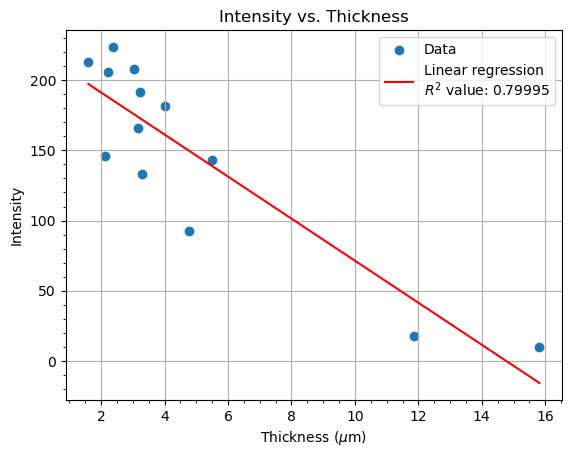

y = -14.97805194142326 x + 221.1779905671675


Would you like to add more images? (yes/no):  no
Would you like to predict the thickness for a new image? (yes/no):  yes
Enter the path for the new image:  C:/Users/sahra/OneDrive/Masaüstü/LightTransmissionImages/60324A.JPG


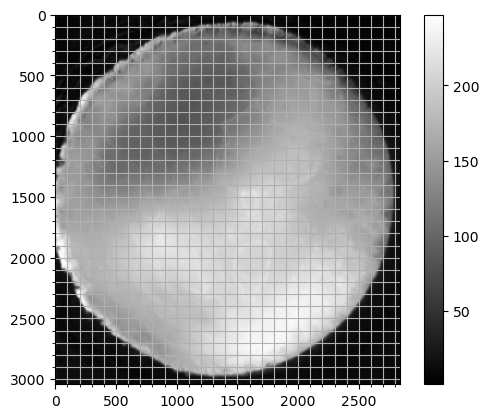

The average intensity for the image is 134.4786
The estimated thickness is 5.7884 μm


In [ ]:
def main():
    thickness, intensities = load_data()

    image_paths, new_thickness = collect_data()
    new_intensities = [process_image(image_path) for image_path in image_paths]
    new_intensities = [i for i in new_intensities if i is not None] 

    if len(new_intensities) > 0:
        thickness.extend(new_thickness)
        intensities.extend(new_intensities)

    if len(intensities) == 0:
        print("No valid intensities calculated.")
        return

    save_data(thickness, intensities)

    reg = plot_intensity_vs_thickness(thickness, intensities)

    while True:
        add_more = input("Would you like to add more images? (yes/no): ").strip().lower()
        if add_more == 'no':
            break

        image_paths, new_thickness= collect_data()
        new_intensities = [process_image(image_path) for image_path in image_paths]
        new_intensities = [i for i in new_intensities if i is not None]

        if len(new_intensities) == 0:
            print("No valid intensities calculated.")
            continue

        thickness.extend(new_thickness)
        intensities.extend(new_intensities)

        save_data(thickness, intensities)

        reg = plot_intensity_vs_thickness(thickness, intensities)
        print(f"Updated model with slope={reg.coef_[0]}, intercept={reg.intercept_}, R^2={reg.score(np.array(thickness).reshape(-1, 1), intensities)}")

    while True:
        predict = input("Would you like to predict the thickness for a new image? (yes/no): ").strip().lower()
        if predict == 'no':
            break

        image_path = input("Enter the path for the new image: ").strip('\"')
        predict_thickness(image_path)

if __name__ == "__main__":
    main()